In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sqlite3
import scipy.stats as stats

from bk_eda import *

pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid")

## EDA

After getting the data and adding it to a database, the next step is to explore the data. Again, the question we are answering is 'How can we predict the contract value of a free agent contract from the player's stats?'. I saved a lot of data into the database. To start, I will look at the following variables:

* position
* height
* weight
* age
* years experience
* games played
* minutes played
* points
* rebounds
* assists
* steals
* blocks
* turnovers
* field goals made
* field goal percentage
* 3pt field goals made
* 3pt field goal percentage
* effective field goal percentage
* free throw percentage
* contract type
* change teams
* contract length
* salary per year

There are other stats in the database that could be used, but I will start with these features for now and will think about adding more features later if needed.

The target variable of interest is salary per year. 

I will start by running a quick query to get the needed data

In [2]:
con = sqlite3.connect('data.db')

In [3]:
query = """
SELECT 
    p.name, c.year, p.position, p.height, p.weight,
    c.age, c.year-p.rookie_year,
    s.games, s.minutes, s.pts, s.trb, s.ast, s.stl, s.blk, s.tov, s.fg, s.fg_per, s.three_fg, s.three_fg_per,
    s.efg_per, s.ft_per, 
    c.type, c.chg_team, c.length, c.avg_dollars
FROM contracts c
JOIN players p
    ON c.id=p.id
JOIN stats s
    ON c.id=s.id AND c.year=s.year
"""

contracts = pd.DataFrame(con.execute(query),
                         columns=['player', 'year', 'position', 'height', 'weight',
                                  'age', 'years_exp',
                                  'games', 'min', 'pts', 'rbs', 'ast', 'stl', 'blk', 'tov', 'fg', 'fg_per',
                                  'three_fg', 'three_per', 'efg_per', 'ft_per',
                                  'type', 'chg_team', 'length', 'avg_dollars'])

I will look at the first few rows of data to make sure that everything looks right and to get an initial understanding of the data.

In [4]:
contracts.iloc[:,:13].head()

,player,year,position,height,weight,age,years_exp,games,min,pts,rbs,ast,stl
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,3.80,2.40,1.10
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,7.90,2.80,0.60
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,6.00,4.30,1.00
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,6.40,5.90,0.70
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,5.30,4.00,1.90


In [5]:
contracts.iloc[:,13:].head()

,blk,tov,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars
0,0.60,1.50,8.40,0.47,3.10,0.40,0.55,0.82,UFA,0,5,37980720
1,0.50,1.80,7.50,0.49,1.90,0.40,0.55,0.87,UFA,0,5,36000000
2,0.10,2.30,6.60,0.44,2.30,0.38,0.52,0.84,UFA,0,5,35500000
3,1.10,2.90,9.20,0.52,1.80,0.35,0.57,0.89,UFA,1,4,41063925
4,0.60,1.50,6.40,0.46,1.00,0.35,0.50,0.85,UFA,1,4,35197650


Now I will check the computer representation of the data.

In [6]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player       355 non-null    object 
 1   year         355 non-null    int64  
 2   position     355 non-null    object 
 3   height       355 non-null    int64  
 4   weight       355 non-null    int64  
 5   age          355 non-null    float64
 6   years_exp    355 non-null    int64  
 7   games        355 non-null    int64  
 8   min          355 non-null    float64
 9   pts          355 non-null    float64
 10  rbs          355 non-null    float64
 11  ast          355 non-null    float64
 12  stl          355 non-null    float64
 13  blk          355 non-null    float64
 14  tov          355 non-null    float64
 15  fg           355 non-null    float64
 16  fg_per       355 non-null    float64
 17  three_fg     355 non-null    float64
 18  three_per    355 non-null    float64
 19  efg_per 

Most of the data in this dataset is represented by floats and ints. The three variables that have object variable types, player, position, and type, are strings. Also, even though chg_team is a categorical variable, it is represented by a float.

## Domain Knowledge

To start, I will quickly outlining what each variable represents and predict how it will relate the target variable. Again the question I am answering is 'How can we predict the contract value of a free agent contract from the player's stats?' and the target variable is avg_dollars.

* avg_dollars - This is the target variable. This is the average salary per year over the life of the contract. 
* player - This is the players name. The players name will not have an influence on how much they make, so this variable will not be considered.
* year - This is the year the player signed the contract. As I want to use this model for predicting this upcoming season, I will not be using this feature in my model because this season is outside the year range of the dataset.
* position - This is the position that player plays. It can be one of five postions: PG, SG, SF, PF, C. As there are players from each position making a variety of different salaries, it is unclear how this will influence avg_dollars.
* height - This is how tall the player is in inches. As height often determines position and from what I said about position, it is unclear at this point how this will influence avg_dollars.
* weight - This is how much the player weighs in pounds. Similar to height, it is unclear how this will influence avg_dollars, as there are lighter and heavier players making a range of different salaries.
* age - This is how old the player is when they signed the contract. I think that middle aged players are likely to make the most variables, as younger players are still establishing themselves and the older players are likely on the downswing of their career.
* years_exp - This is how many years the player has been in the league. Similar to the age, I think players who have been in the league a medium number of years (5-10) will likely make the most money.
* games - This is how many games the player played in the previous year. I think that players who played more games are more likely to make more money than players who played less games.
* min - This is how many minutes the player played on average each game. I think that players who played more minutes are more likely to make more money than players who played less minutess.
* pts - This is how many points the player scores on average each game. I think that players who score more points are more likely to make more money than players who score less.
* rbs - This is the number of rebounds the player gets on average each game. I think that players who grab more rebounds are more likely to make more money than players who got less rebounds.
* ast - This is the number of assists the player got on average each game. I think that players who got more assists are more likely to make more money than players who had less.
* stl - This is the number of steals the player had on average each game. I think that players who got more steals are more likely to make more money than players who had less.
* blk - This is the number of shots the player blocked on average each game. I think that players who blocked more shots are more likely to make more money than the players who blocked less.
* tov - This is the number of times the player turned the balled over each game. I think that players who turned the ball over less will make more money than people who turn it over a lot.
* fg - This is the number of shots the player makes on average per game. I think that players who make more shots are more likely to make more money than players who make less.
* fg_per - This is the percentage of the shots the player takes that he makes. I think that players who have a higher field goal percentage are more likely to make more money on their contract.
* 3pt field goals made - This is the number of three point shots the player makes on average per game. I think that players who make more three point shots are more likely to make more money than players who make less.
* 3pt field goal percentage - This is the percentage of three point shots the player takes that he makes. I think that players who have a higher three point percentage are more likely to make more money on their contract.
* effective field goal percentage - This is a newer statistic to measure field goal percentage that weights three point shot makes higher than two point shot makes. The foluma for this is as follows $eFG = \frac{2pt + 1.5*3pt}{total attempts}$. This weights 3 point makes 1.5 times more than 2 point makes because that is $2*1.5=3$. I think that players with a higher effect field goal percentage will make more money than those with less.
* ft_per - This is the percentage of free throws the player takes that he makes. I think that players who have a higher free throw percentage are more likely to make more money on their contract.
* type - This is the type of contract the player is signing. I think that players who sign Unrestricted Free Agent contracts (UFA) will make more than others.
* chg_teams - This is whether or not the free agent resigned with their team from the previous year. If the player changed teams, the feature value is 1. If they did not, the feature value is 0. I am not entirely sure the impact this will have on contract value.
* length - This is the number of years the contract is for. As players likely trade a little bit of salary per season in exchange for long term security, I think that players with a shorter length contract will have a higher average salary per year.

While this definitely, does not tell the whole story, it is a good place to start.

## Single Variable EDA

### avg_dollars

avg_dollars is the main variable of interest. avg_dollars represents the yearly salary for the contract that is signed. avg_dollars is numeric variable and is represented by positive floats (real values). Prior to looking at the data, it is hard to say too much about the expected distribution of the data, but as this is the salary per year, it is possible that avg_dollars roughly follows a Poisson distribution.

Here are some descriptive statistics for the rings variable:

In [7]:
descriptive_stats_single_numeric(contracts['avg_dollars'])

,Stats
count,355.00
mean,"6,772,490.30"
std,"7,879,993.54"
min,"898,310.00"
25%,"2,058,317.50"
50%,"3,150,000.00"
75%,"8,528,461.00"
max,"44,066,288.00"
range,"43,167,978.00"
iqr,"6,470,143.50"


The mean is much larger than the median and the difference between the minimum and the median is much smaller than the difference between the median and the maximum suggesting the data is heavily skewed left. Let's look at a histogram of the data to get a better idea of this.

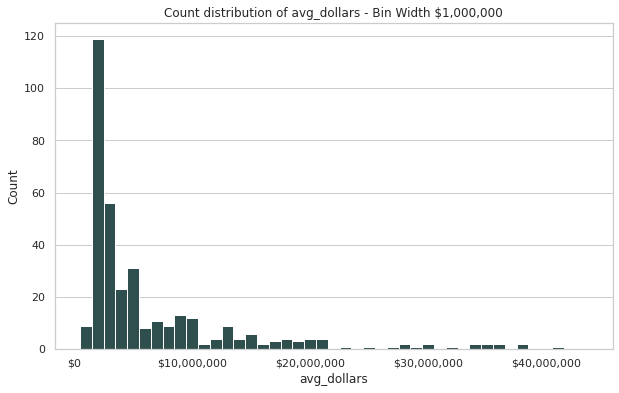

In [8]:
bins = [i for i in range(500000, 44500000, 1000000)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['avg_dollars'], bins=bins, color="darkslategray")
axes.set_xticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_xticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_title("Count distribution of avg_dollars - Bin Width $1,000,000")
axes.set_xlabel('avg_dollars')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

A majority of the contracts signed were under 5,000,000 dollars, specifically between 1 and 1.5 million dollars. This make sense as a lot of rookie and minimum contracts are likely in this range. I will look to the other statistics to see if I can distinquish between the different contract values.

### position

position is the position of the player plays. Position is categorical variable and is represented by a string. The distribution of the different positions should be roughly evenly distributed, although Center is a less prominent position in today's game, so this position might be slightly less represented.

Here are the value counts for position

In [9]:
pd.DataFrame(contracts['position'].value_counts())

,position
SG,86
PF,79
PG,72
C,66
SF,52


The number of each position represented in the dataset definitely isn't evenly distributed. This is likely a result of the particular free agents from these years. Taking a look at these value counts in a chart:

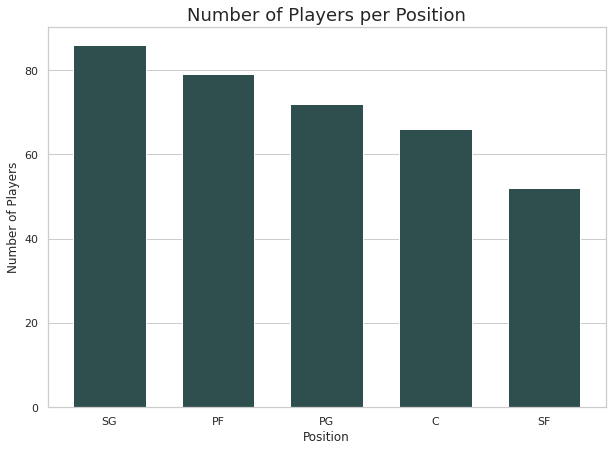

In [10]:
width = 1/1.5
x = range(len(contracts['position'].value_counts().values))

figure = plt.figure(figsize=(10, 7))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, contracts['position'].value_counts().values, width, color='darkslategray', align='center')
axes.set_xticks([0, 1, 2, 3, 4])
axes.set_xticklabels(['SG', 'PF', 'PG', 'C', 'SF'])
axes.set_title('Number of Players per Position', fontsize=18)
axes.set_xlabel('Position')
axes.set_ylabel('Number of Players')
axes.yaxis.grid(b=True, which='major')
axes.xaxis.grid(b=False)

plt.show()
plt.close()

### height

position is how tall the player is in inches. Height is a numeric variable and is represented by an int. The distribution of the height should be roughly normally distributed, as there is likely an mean height in the NBA and most heights are likely centered around this mean.

Here are some descriptive statistics:

In [11]:
descriptive_stats_single_numeric(contracts['height'])

,Stats
count,355.00
mean,78.39
std,3.40
min,69.00
25%,76.00
50%,78.00
75%,81.00
max,89.00
range,20.00
iqr,5.00


The mean and median are very similar, suggesting that the prediction that the data follows a normal distribution was likely a good one. Let's take a look at a histogram.

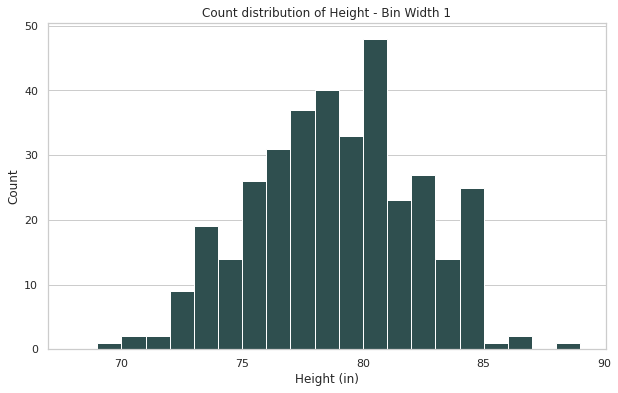

In [12]:
bins = [i for i in range(68, 90, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['height'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Height - Bin Width 1")
axes.set_xlabel('Height (in)')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is not exactly normally distributed and appears to be reach a peak just to the right of the mean.

### weight

weight is how much the player weighs in pounds. Weight is a numeric variable and is represented by an int. The distribution of the weight should be roughly normally distributed, as there is likely an weight height in the NBA and most weights are likely centered around this mean.

Here are some descriptive statistics:

In [13]:
descriptive_stats_single_numeric(contracts['weight'])

,Stats
count,355.00
mean,219.01
std,25.12
min,167.00
25%,200.00
50%,217.00
75%,237.50
max,311.00
range,144.00
iqr,37.50


The mean and median are very similar, suggesting that the prediction that the data follows a normal distribution was probably pretty accurate. Let's take a look at a histogram.

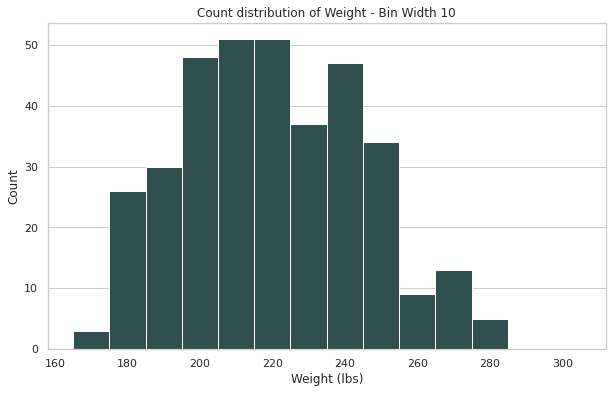

In [14]:
bins = [i for i in range(165, 311, 10)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['weight'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Weight - Bin Width 10")
axes.set_xlabel('Weight (lbs)')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data does appear to follow a normal distribution fairly closely.

### age

age is how old the player was when they signed the free agent contract. Age is a numeric variable and is represented by a float. There are likely more younger players (under the age of 24) than older players because many players play for a couple years and then fall out of the league. Thus, I expect the younger ages to be highly represented in this analysis.

Here are some descriptive statistics:

In [15]:
descriptive_stats_single_numeric(contracts['age'])

,Stats
count,355.00
mean,34.12
std,105.86
min,20.70
25%,25.35
50%,28.10
75%,31.05
max,"2,021.70"
range,"2,001.00"
iqr,5.70


It appears that there may be an age that is incorrect in the dataset. Let's take a look at the players that are over the age of 45, as there should be no players over this age.

In [16]:
contracts[contracts['age']>45]

,player,year,position,height,weight,age,years_exp,games,min,pts,...,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars
350,Jarrell Brantley,2021,PF,77,250,"2,021.70",1,28,4.90,2.30,...,0.90,0.48,0.40,0.43,0.60,1.00,RFA,0,1,1669178


This is an error on the website, as Jarrell Brantley is listed as 2021.70 years old. The [NBA website](https://www.nba.com/stats/player/1629714/career/) lists Mr. Brantley's birthday as 06/07/1996, which would make him roughly 25.1 years old when he signed this contract. I will adjust his age in `contracts`.

In [17]:
contracts.at[350, 'age'] = 25.1

Checking to see that Jarrell Brantley's age is fixed and there are no other ages greater than 45.

In [18]:
contracts.loc[350]

player         Jarrell Brantley
year                       2021
position                     PF
height                       77
weight                      250
age                       25.10
years_exp                     1
games                        28
min                        4.90
pts                        2.30
rbs                        1.00
ast                        0.50
stl                        0.30
blk                        0.10
tov                        0.30
fg                         0.90
fg_per                     0.48
three_fg                   0.40
three_per                  0.43
efg_per                    0.60
ft_per                     1.00
type                        RFA
chg_team                      0
length                        1
avg_dollars             1669178
Name: 350, dtype: object

In [19]:
contracts[contracts['age']>45]

,player,year,position,height,weight,age,years_exp,games,min,pts,...,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars


I will also update the database so as not to include this error in the future.

In [20]:
con.execute('''
UPDATE contracts
SET age = 25.1
WHERE name = "Jarrell Brantley"
''')
con.commit()

Checking to make sure this update completed properly with a simple query.

In [21]:
query = """
SELECT *
FROM contracts
WHERE name = "Jarrell Brantley"
"""

temp = pd.DataFrame(con.execute(query),
                         columns=['id', 'year', 'name', 'age', 'type', 'old_team', 'new_team',
                                  'chg_team', 'length', 'total_dollars', 'avg_dollars'])
temp

,id,year,name,age,type,old_team,new_team,chg_team,length,total_dollars,avg_dollars
0,621,2021,Jarrell Brantley,25.10,RFA,UTH,UTH,0,1,1669178,1669178


Ok, now that that is fixed, back to descriptive statistics.

In [22]:
descriptive_stats_single_numeric(contracts['age'])

,Stats
count,355.00
mean,28.50
std,4.00
min,20.70
25%,25.30
50%,28.10
75%,31.00
max,42.60
range,21.90
iqr,5.70


The mean age is close to the median. However, the distance from the minimum to the median is much smaller than the distance from the median to the maximum, suggesting the data will be skewed to the right.

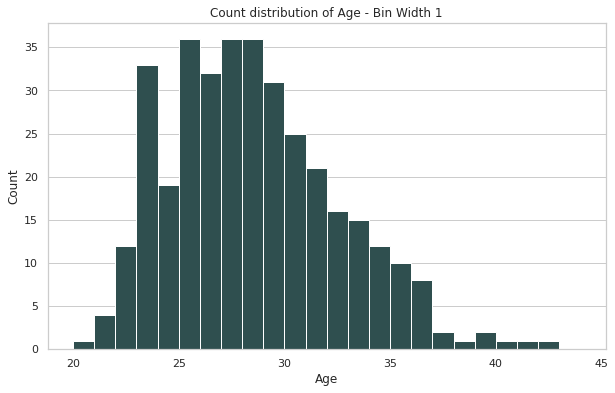

In [23]:
bins = [i for i in range(20, 45, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['age'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Age - Bin Width 1")
axes.set_xlabel('Age')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right, but it is a lot closer to normally distributed than I expected.

### years_exp

years_exp is how many years the player has been in the NBA. Year_exp is a numeric variable and is represented by an int. years_exp is probably highly related to age, as players typically come into the league around the same age (between 19-21). Therefore, I expect the distribution of years_exp to be very similar to that of age.

Here are some descriptive statistics:

In [24]:
descriptive_stats_single_numeric(contracts['years_exp'])

,Stats
count,355.00
mean,5.79
std,4.11
min,0.00
25%,3.00
50%,5.00
75%,8.00
max,20.00
range,20.00
iqr,5.00


The mean is slightly bigger than the median, suggesting the data will be skewed to the right. However, the distance from the minimum to the median is much smaller than the distance from the median to the maximum, suggesting that the distribution will be more heavily skewed than `age`.

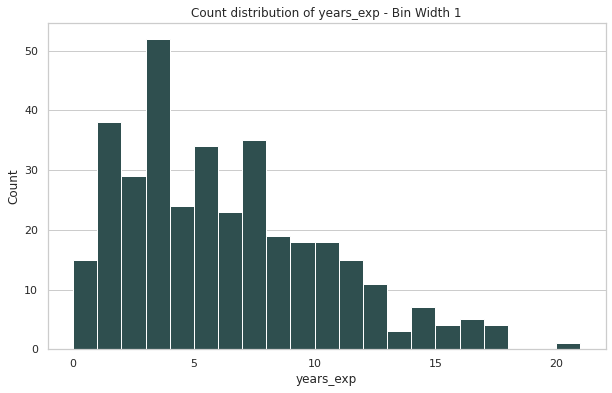

In [25]:
bins = [i for i in range(0, 22, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['years_exp'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of years_exp - Bin Width 1")
axes.set_xlabel('years_exp')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is more heavily skewed to the right. We see some spikes at year 3, 5, and 7. This makes sense as this corresponds to some of the timelines of rookie contracts and rookie extensions, where a lot of players will be entering free agency.

### games

games is how many games the player played in the season before they hit free agency. Games is a numeric variable and is represented by an int. games is probably skewed to the left, with most players entering free agency likely playing around 60-70 games the year before.

Here are some descriptive statistics:

In [26]:
descriptive_stats_single_numeric(contracts['games'])

,Stats
count,355.00
mean,51.80
std,19.21
min,1.00
25%,39.00
50%,56.00
75%,66.00
max,82.00
range,81.00
iqr,27.00


The mean is smaller than the median, suggesting the data will be skewed to the left. Taking a look at the histogram:

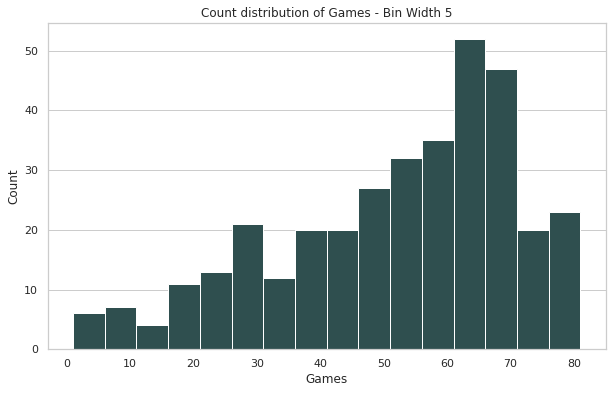

In [27]:
bins = [i for i in range(1, 82, 5)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['games'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Games - Bin Width 5")
axes.set_xlabel('Games')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is heavily skewed to the right, although there are some players that played very few games the year before entering free agency. As I expected, it seems like most players played between 60 and 70 games.

### min

min is how many minutes the player played per game the year before entering free agency. Min is a numeric variable and is represented by a float. There is likely an mean number of minutes per game played in the NBA with most players playing a number of minutes somewhere around this mean. Therefore, I expect the distribution of min to roughly follow a normal distribution.

Here are some descriptive statistics:

In [28]:
descriptive_stats_single_numeric(contracts['min'])

,Stats
count,355.00
mean,20.76
std,7.45
min,2.00
25%,15.70
50%,20.90
75%,26.45
max,35.70
range,33.70
iqr,10.75


The mean number of minutes is very similar to the median. However, the difference between the minimum and median min is much larger than the difference between the median and the maximum number of minutes, suggesting the data could be skewed to the left.

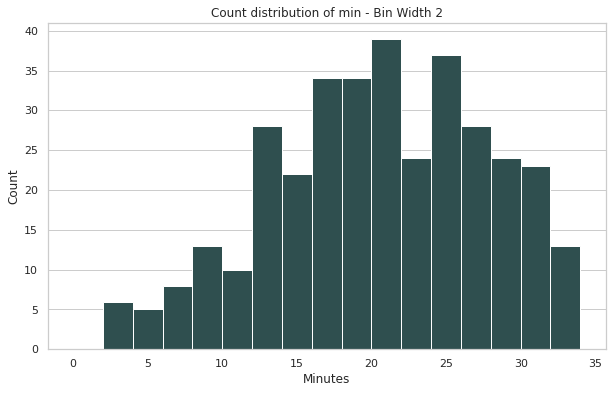

In [29]:
bins = [i for i in range(0, 36, 2)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['min'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of min - Bin Width 2")
axes.set_xlabel('Minutes')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right a little, but aside from some players playing exceptionally low amounts, there is a semblance of a normal distribution.

### pts

pts is how many points the player scored per game the year before entering free agency. pts is a numeric variable and is represented by a float. As there are a group of players that score a considerable amount more than other players, I expected this data to be slightly skewed to the right. Also, as this is per game data, it is possible the data roughly follows a Poisson distribution.

Here are some descriptive statistics:

In [30]:
descriptive_stats_single_numeric(contracts['pts'])

,Stats
count,355.00
mean,8.86
std,5.01
min,0.10
25%,5.40
50%,7.70
75%,11.25
max,26.60
range,26.50
iqr,5.85


The mean number of minutes is larger than the median and the difference between the minimum and median min is much smaller than the difference between the median and the maximum number of minutes, suggesting the data is likely skewed to the right.

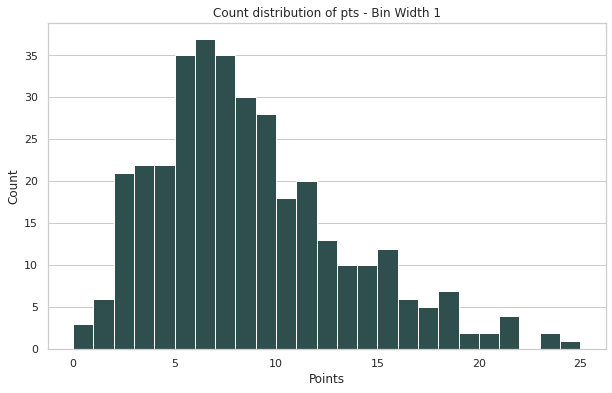

In [31]:
bins = [i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['pts'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of pts - Bin Width 1")
axes.set_xlabel('Points')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right a little. While I definitely would not say the data follows a Poisson distribution, the outline of that shape is apparent in the data.

### rbs

rbs is how many rebounds the player grabbed per game the year before entering free agency. Rbs is a numeric variable and is represented by a float. Unlike points, I think the number of rebounds players grab is likely more closer to a normal distribution, as there are less extreme rebounding numbers as opposed to points. Still, as this is per game data, rebounds could roughly follow a Poisson distribution.

Here are some descriptive statistics:

In [32]:
descriptive_stats_single_numeric(contracts['rbs'])

,Stats
count,355.00
mean,3.82
std,2.10
min,0.30
25%,2.40
50%,3.50
75%,4.90
max,13.50
range,13.20
iqr,2.50


The mean number of rebounds is very similar to the median. However, the difference between the minimum and median rebounds grabbed is much smaller than the difference between the median and the maximum number of rebounds per game, suggesting the data should be skewed right.

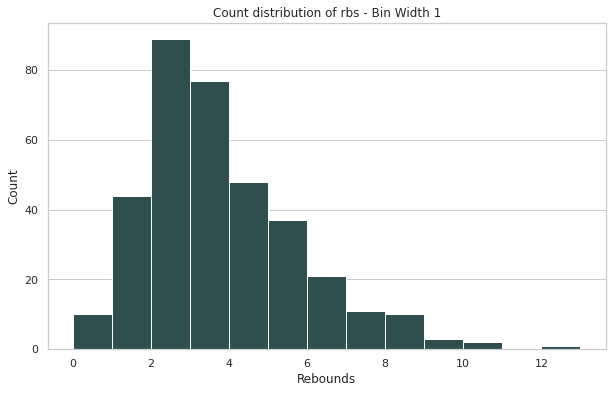

In [33]:
bins = [i for i in range(0, 14, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['rbs'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of rbs - Bin Width 1")
axes.set_xlabel('Rebounds')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right and unlike my prediction, more closely resembles a Poisson distribution than a normal distribution.

### ast

ast is how many assists the player had per game the year before entering free agency. Ast is a numeric variable and is represented by a float. I believe assists will have a similar distribution to that of rebounds, although I am guessing the maximum number of assists per game will be lower than the maximum rebounds per game.

Here are some descriptive statistics:

In [34]:
descriptive_stats_single_numeric(contracts['ast'])

,Stats
count,355.00
mean,1.90
std,1.51
min,0.00
25%,0.90
50%,1.50
75%,2.30
max,8.90
range,8.90
iqr,1.40


The mean number of assists is very smaller and slightly larger than the median. I believe that it is a safe prediction to safe this data will be heavily skewed to the right.

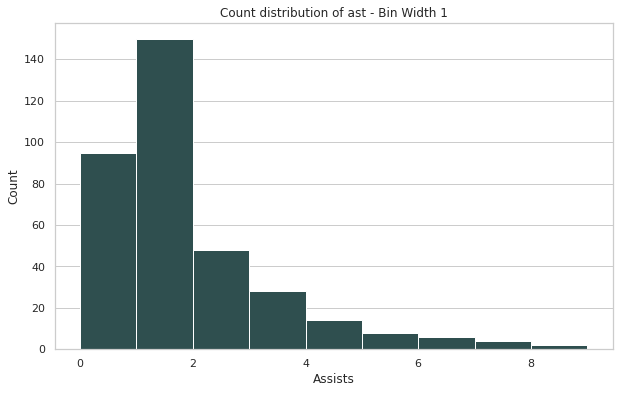

In [35]:
bins = [i for i in range(0, 10, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['ast'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of ast - Bin Width 1")
axes.set_xlabel('Assists')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

As expected the data is heavily skewed to the right. The data appears to very closely follow a Poisson distribution.

### stl

stl is how many steals the player had per game the year before entering free agency. Stl is a numeric variable and is represented by a float. I believe steals will have a similar distribution to assists, but the range for steals will be much smaller.
Here are some descriptive statistics:

In [36]:
descriptive_stats_single_numeric(contracts['stl'])

,Stats
count,355.00
mean,0.66
std,0.36
min,0.00
25%,0.40
50%,0.60
75%,0.90
max,2.00
range,2.00
iqr,0.50


The mean number of steals is higher than the median and the distance between the minimum and the median is much smaller than the distance between the median and the maximum. Thus, I believe the data skewed to the right.

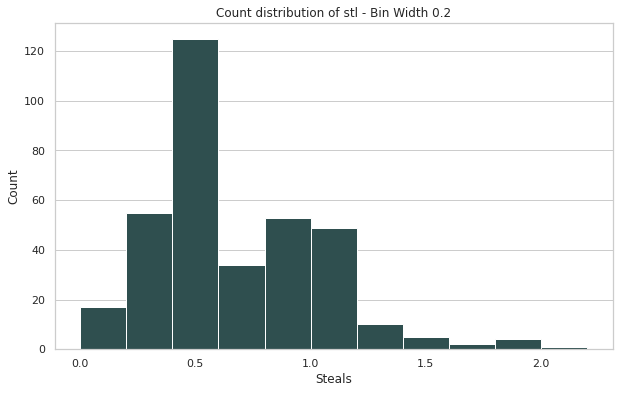

In [37]:
bins = [0.2*i for i in range(0, 12, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['stl'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of stl - Bin Width 0.2")
axes.set_xlabel('Steals')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

As expected the data is heavily skewed to the right and roughly follows the outline of a Poisson distribution.

### blk

blk is how many blocks the player made per game the year before entering free agency. Blk is a numeric variable and is represented by a float. I believe blocks will have a very similar distribution to steals and I think the range for the values of blocks will be very similar to steals as well.

Here are some descriptive statistics:

In [38]:
descriptive_stats_single_numeric(contracts['blk'])

,Stats
count,355.00
mean,0.42
std,0.39
min,0.00
25%,0.20
50%,0.30
75%,0.50
max,2.90
range,2.90
iqr,0.30


The difference between the minimum and median number of blocks per game is much smaller than the difference between the median and maximum number of blocks, so the data should be heavily skewed right.

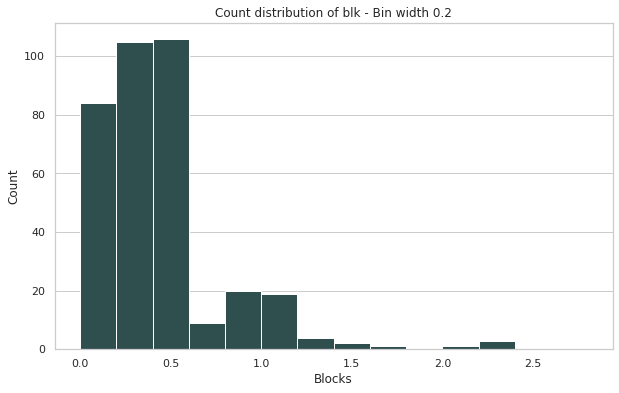

In [39]:
bins = [0.2*i for i in range(0, 15, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['blk'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of blk - Bin width 0.2")
axes.set_xlabel('Blocks')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The large majority of players have 0.6 blocks per game or less, with just a relatively few players having more.

### tov

tov is how many times the player turned the ball over per game the year before entering free agency. Tov is a numeric variable and is represented by a float. I believe turnovers could be more normally distributed than some of the other features, but there is still a chance the data roughly follows a Poisson distribution because it is per game data.

Here are some descriptive statistics:

In [40]:
descriptive_stats_single_numeric(contracts['tov'])

,Stats
count,355.00
mean,1.04
std,0.58
min,0.00
25%,0.70
50%,0.90
75%,1.30
max,3.10
range,3.10
iqr,0.60


While the difference between the distance from the minimum and median and the distance between the median and the maximum still suggests that the data is skewed right, it does not appear to be quite as skewed as some of the other features. Taking a look at the histogram of the data:

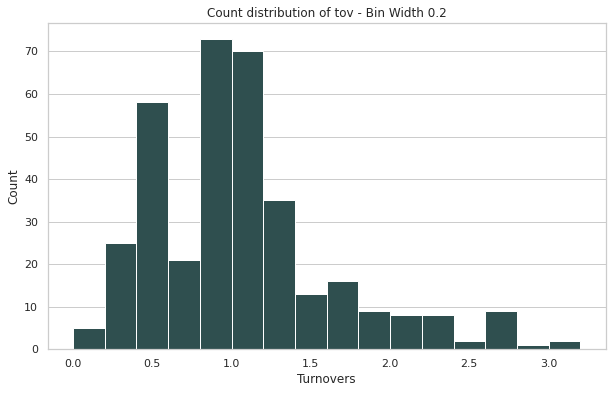

In [41]:
bins = [0.2*i for i in range(0, 17, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['tov'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of tov - Bin Width 0.2")
axes.set_xlabel('Turnovers')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

While the data may be less skewed than the other features, it is definitely still skewed right. Also, there is a strange gap in the 0.6-0.8 turnovers range. 

### fg

fg, or field goals, is the number shots the player made per game the year before entering free agency. fg is a numeric variable and is represented by a float since it is an average. As points is very closely related to the number of shots the player makes, I believe field goals will have a very similar distribution to points.

Here are some descriptive statistics:

In [42]:
descriptive_stats_single_numeric(contracts['fg'])

,Stats
count,355.00
mean,3.28
std,1.81
min,0.00
25%,2.05
50%,2.90
75%,4.10
max,9.30
range,9.30
iqr,2.05


The mean is larger than the median and the distance between the minimum and median is smaller than the distance from the median to the maximum. For these reasons, I think the data will be skewed right.

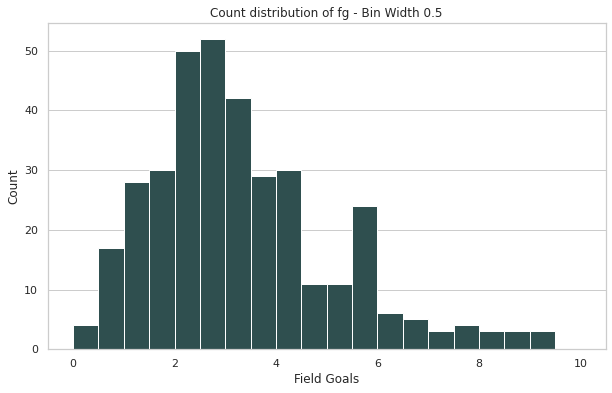

In [43]:
bins = [0.5*i for i in range(0, 21, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['fg'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of fg - Bin Width 0.5")
axes.set_xlabel('Field Goals')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

Much like most of the features in the data set, the distribution is skewed right.

### fg_per

fg_per, or field goal percentage, is the percentage of shots the player takes that he makes the season before entering free agency. fg_per is a numeric variable and is represented by a float between 0 and 1. As this feature is a proportion, I think that it is more likely to follow a rough normal distribution.

Here are some descriptive statistics:

In [44]:
descriptive_stats_single_numeric(contracts['fg_per'])

,Stats
count,355.00
mean,0.46
std,0.09
min,0.00
25%,0.41
50%,0.45
75%,0.50
max,1.00
range,1.00
iqr,0.09


Compared to the other features, the mean is much closer to the median. Let's see what the distribution of the feature looks like in a histogram.

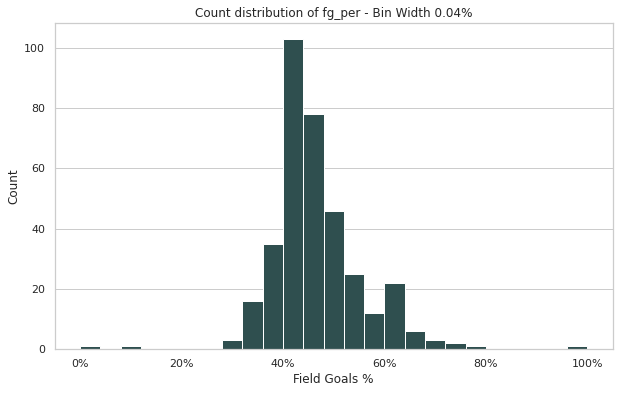

In [45]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['fg_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of fg_per - Bin Width 0.04%")
axes.set_xlabel('Field Goals %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

While there are some extreme values, this feature is much closer to a normal distribution. However, the data is still slightly skewed to the right. Zooming in on the main portion of the data might show this better.

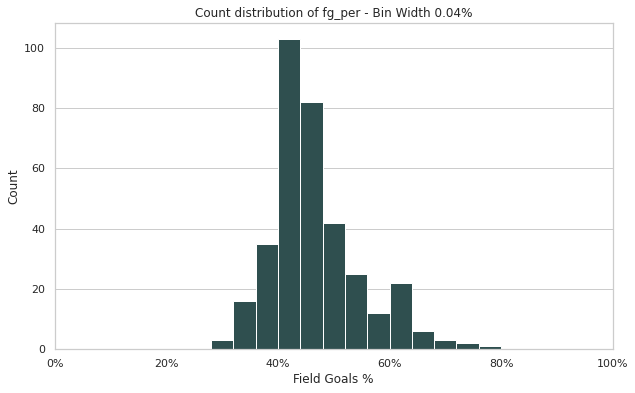

In [46]:
bins = [0.04*i+0.2 for i in range(0, 16, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['fg_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of fg_per - Bin Width 0.04%")
axes.set_xlabel('Field Goals %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

Yes, this data is still skewed to the right.

### three_fg

three_fg, or three point field goals, is the number three point shots the player made per game the year before entering free agency. three_fg is a numeric variable and is represented by a float since it is an average. While not as skewed as some of the other statistics, I expect this feature to be skewed similar to fg.

Here are some descriptive statistics:

In [47]:
descriptive_stats_single_numeric(contracts['three_fg'])

,Stats
count,355.00
mean,1.01
std,0.80
min,0.00
25%,0.30
50%,0.90
75%,1.50
max,3.50
range,3.50
iqr,1.20


The mean is larger than the median and the median is closer to the minimum than the maximum, suggesting the data will be skewed to the right.

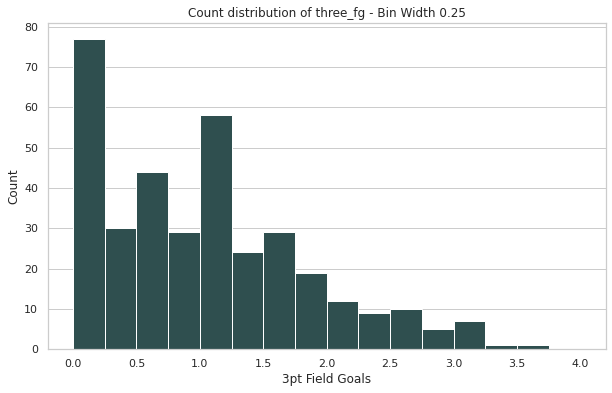

In [48]:
bins = [0.25*i for i in range(0, 17, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['three_fg'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of three_fg - Bin Width 0.25")
axes.set_xlabel('3pt Field Goals')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The distribution is closer to an exponential distribution than a Poission distribution. The distribution makes sense due to the fact that a lot of post players do not take many threes.

## three_per

three_per, or three point field goal percentage, is the percentage of three point shots the player takes that he makes the season before entering free agency. three_per is a numeric variable and is represented by a float between 0 and 1. Like fg_per, I think this feature will be slightly skewed to the right with some extreme values.

Here are some descriptive statistics:

In [49]:
descriptive_stats_single_numeric(contracts['three_per'])

,Stats
count,355.00
mean,0.32
std,0.13
min,0.00
25%,0.29
50%,0.35
75%,0.39
max,1.00
range,1.00
iqr,0.10


The mean is slightly lower than the median, suggesting this distribution might be slightly skewed to the left. Also, much like I predicted, there appear to be some extreme values. Lastly, it is interesting to note that the IQR is very small for this particular feature.

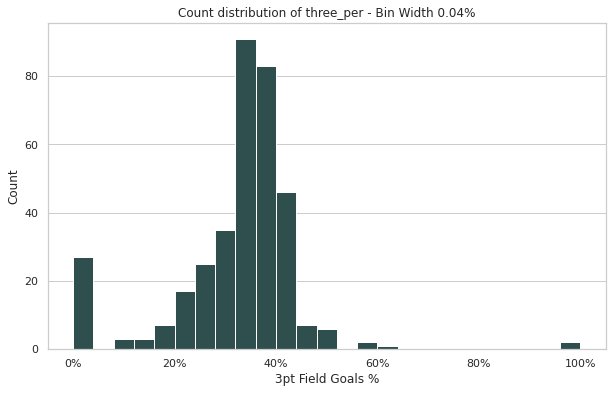

In [50]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['three_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of three_per - Bin Width 0.04%")
axes.set_xlabel('3pt Field Goals %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

This distribution is very intersting because there is a spike at between 0.00 and 0.04. This is likely the group of players who do not shoot a large number of threes. Of the players we can assume tend to shoot more threes, most players shoot between 36-42%.

## efg_per

efg_per, or effective field goal percentage, is a weighted field goal percentage. It weights three point shots 1.5 times more than two point shots, as threes are more valuable. It has grown in popularity in recent years and has inspired other variations of weighted field goal percentages, such as True Shooting Percentage. [Here is a link](https://www.basketball-reference.com/about/glossary.html) to some definiteions of effective field goal percentage and true shooting percentage. 
<br>efg is a numeric variable and is represented by a float between 0 and 1. As effective field goal percentage is very closely related to field goal percentage, I believe efg_per will have a similar distribution to fg_per.

Here are some descriptive statistics:

In [51]:
descriptive_stats_single_numeric(contracts['efg_per'])

,Stats
count,355.00
mean,0.53
std,0.08
min,0.00
25%,0.49
50%,0.53
75%,0.57
max,1.00
range,1.00
iqr,0.08


The median and the mean are exactly the same and the first quartile and third quartile are evenly spaced around the mean. These values suggest the data might follow a normal distributed, let's take a look at the histogram.

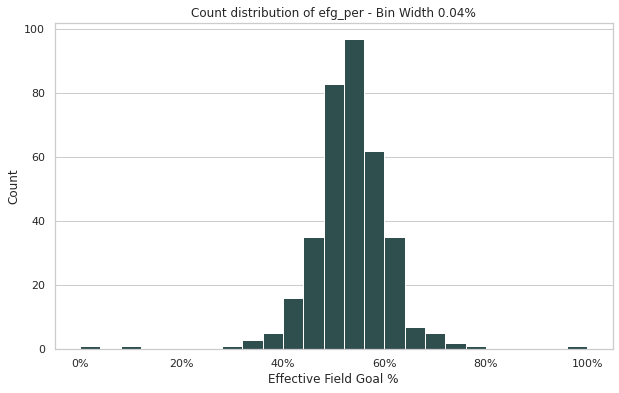

In [52]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['efg_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of efg_per - Bin Width 0.04%")
axes.set_xlabel('Effective Field Goal %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

Unlike almost all of the other features, the data follows a rough normal distribution. Like the other percentage features, there are also some extreme values.

## ft_per

ft_per, or free throw percentage, is the percentage of free throws the player took that he made the season before entering free agency. ft_per is a numeric variable and is represented by a float between 0 and 1. As there are more players that shoot very high free throw percentages than lower ones, I think this feature will be skewed left.

Here are some descriptive statistics:

In [53]:
descriptive_stats_single_numeric(contracts['ft_per'])

,Stats
count,355.00
mean,0.75
std,0.13
min,0.00
25%,0.70
50%,0.78
75%,0.83
max,1.00
range,1.00
iqr,0.13


The mean is smaller than the median, suggesting the prediction that the data is skewed left might be a good one.

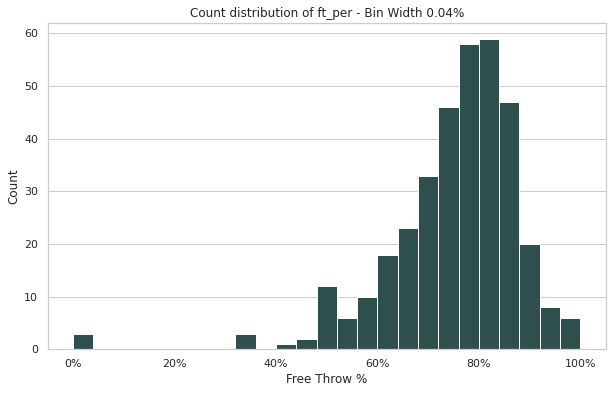

In [54]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['ft_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of ft_per - Bin Width 0.04%")
axes.set_xlabel('Free Throw %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The free throw percentage does appear to be skewed to the left.

### type

type is the type of contract that the player signs. I expect that RFA, restricted free agent, and UFA, unrestricted free agent, will be in the dataset, but I am not sure if there will be any other types. Let's run a value counts to see if the data set has any other types.

In [55]:
pd.DataFrame(contracts['type'].value_counts())

,type
UFA,302
RFA,53


As we can see from the table, these are the only two types of contracts signed. As RFA contracts are only signed by players after their rookie deals, it does not surprise me that there are a lot more examples of UFA in the dataset.

### chg_team

chg_team is a boolean value that shows whether or not the free agent signed with a new team. If the player resigned with the same team, the chg_team value is 0. If they signed with a new team, the chg_team value is 1. Taking a look at the value counts of the `chg_team`.

In [56]:
pd.DataFrame(contracts['chg_team'].value_counts())

,chg_team
1,219
0,136


As we can see from the table, it looks like roughly $\frac{2}{3}$ of players changed teams in this data set.

### length

length is the number of years of the contract that the player signed. As NBA players can sign between 1 and 5 year contracts, the values for `length` should be between 1 and 5. Let's do a quick value counts to see if this is in fact the case.

In [57]:
pd.DataFrame(contracts['length'].value_counts())

,length
1,151
2,104
3,59
4,32
5,9


As we can see here, the shorter contracts are more common. A histogram will show this downward trend very clearly.

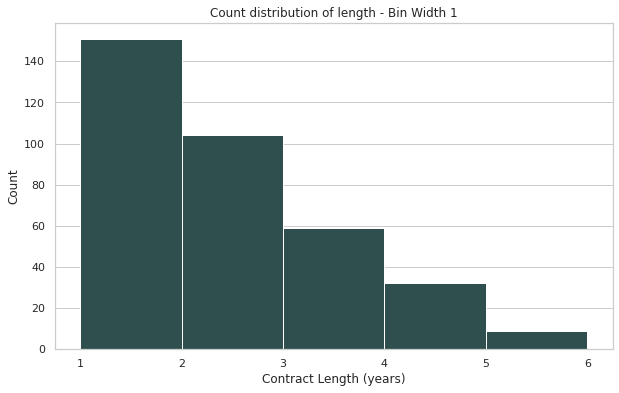

In [58]:
bins = [i for i in range(1, 7, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['length'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of length - Bin Width 1")
axes.set_xlabel('Contract Length (years)')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

**Single Variable EDA Thoughts:** One thing that stands out in particular from the single variable EDA is that many of the features in the data set have values that are skewed to the right. Also, many of the features roughly follow a Poisson distribution, which makes sense because the data is per game statistics.

## Two Variable EDA

After looking into each of the variables individually, I will move on to looking at the relationships between multiple variables. I will not check every single the relationship between every single pair of features, but I will pay particular attention to the relationship between each variable and `avg_dollars` and any pairs that are likely related to one another.

### avg_dollars vs pts

I will start two variable EDA by looking at the relationship between avg_dollars and points. Points is the statistic that gets the most attention by the media and when deciding awards, so there is likely a decent relationship between salary and points. 

I will start by looking at the values of Pearson's and Spearman's correlation coefficients to see if there appears to be a relationship between the two features.

In [59]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['pts'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['pts'])[0])

r   =  0.7656338638695737
rho =  0.690041342372558


There appears to be a relatively strong positive relationship between points per game and avg_dollars. Let's take a look at what the scatter plot for this relationship looks like.

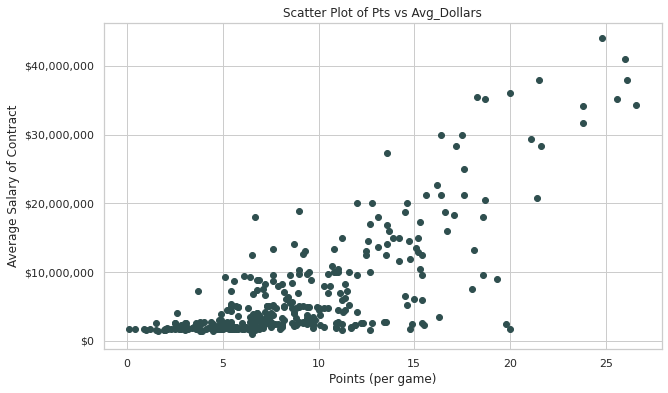

In [60]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['pts'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Points (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Pts vs Avg_Dollars")

plt.show()
plt.close()

There is a large cluster of players making fairly lower salaries that had anywhere from 0 to 20 points per game. However, a large majority of the time, the players who are signing the largest contracts are the players who score the most points.

### avg_dollars vs age

Next, I will take a look at the relationship between avg_dollars and age. I hypothesize that middle aged players, likely between 24-32 will make more money than the younger and older players. This is because younger players are likely getting rookie deals and the older players are likely on the down slope of their career.

In [61]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['age'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['age'])[0])

r   =  0.04768423514756636
rho =  0.28483384893138164


There does not appear to be any linear relationship. Let's see if the scatter plot confirms my hypothesis about middle aged players.

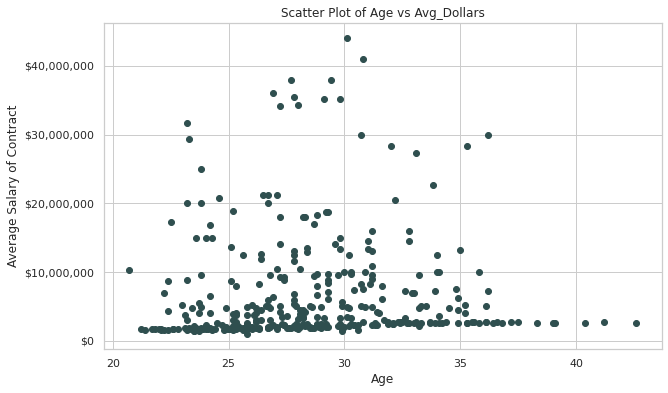

In [62]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['age'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Age")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Age vs Avg_Dollars")

plt.show()
plt.close()

The middle age players are the players that make the higher salaries. However, the key for this project will be figuring out what seperates the players that make the minimum salary (the straight line on the bottom) and the players that get the higher salaries.

### age vs. years_exp

Before moving on to compare the next feature with avg_dollars, I want to check the relationship between age and years_exp. As players often come into the league around the same age, it is likely that there is a strong relationship between the two.

I will start by looking at the values of Pearson's and Spearman's correlation coefficients:

In [63]:
print("r   = ", stats.pearsonr( contracts['age'], contracts['years_exp'])[0])
print("rho = ", stats.spearmanr( contracts['age'], contracts['years_exp'])[0])

r   =  0.9055220445655147
rho =  0.8824345031355126


There appears to be a very strong relationship between the two. Let's have a look at the scatter plot of these two features.

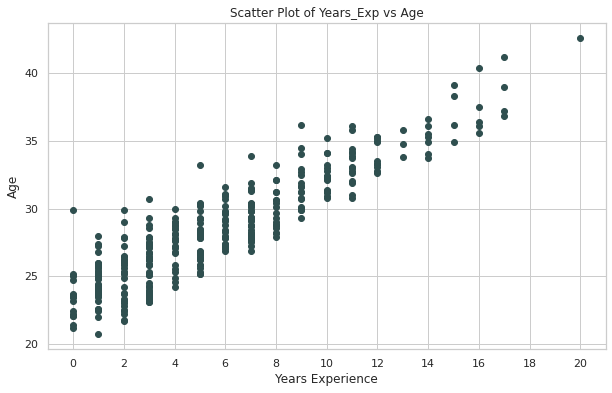

In [64]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['years_exp'], contracts['age'], marker="o", color="darkslategray")
axes.set_xticks(list(range(0, 22, 2)))
axes.set_xlabel("Years Experience")
axes.set_ylabel("Age")
axes.set_title("Scatter Plot of Years_Exp vs Age")

plt.show()
plt.close()

There is definitely a strong relationship between these two features. This is something that I will keep in mind when building the model, as the one of the features likely does not need to be included. From an abstract point of view, it seems more correct to say age leads to years of experience, as opposed to years of experience leading to age. This along with the fact that the distribution for age is smoother than years means I will likely use age in the model.

### avg_dollars vs height

Next, I will take a look at the relationship between avg_dollars and height. You often heare people say that taller people would be better basketball players, but do taller baskeatball players make more money? I believe there are valuable players at all different heights, as teams need good guards, wings, and bigs. Thus, I don't expect much of a relationship between height and avg_dollars.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [65]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['height'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['height'])[0])

r   =  -0.02463303725115754
rho =  0.02854322973801204


The value for r and rho are extremely low. The scatter plot should show no relation.

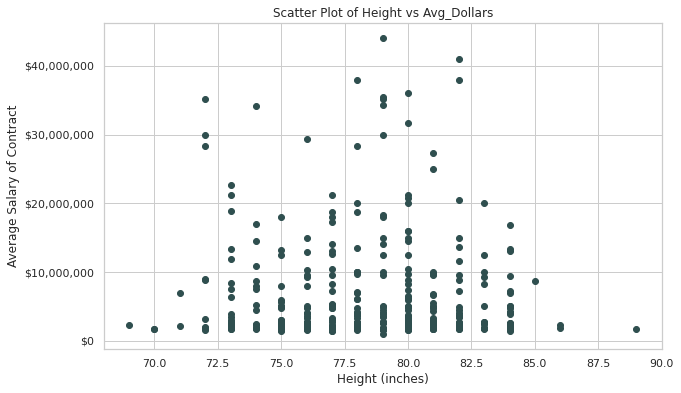

In [66]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['height'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Height (inches)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Height vs Avg_Dollars")

plt.show()
plt.close()

As we can see from the scatter plot, the salaries of these free agents varies for each of the different heights. If we look at the heights between 72 inches and 84 inches (6ft and 7ft), the only real thing that stands out is that these players are more common than players outside of this range.

### avg_dollars vs games

Now I will take a look at the relationship between avg_dollars and games. The players that are the better players on their team likely play in all the games they can, so their is likely a positive relationship between games played and salary. However, sometimes better players get injured or rest for some games, so this relationship likely won't be perfect.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [67]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['games'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['games'])[0])

r   =  0.3818571547702418
rho =  0.5497478313425618


There is a positive relationship, but it is a pretty weak relationship. This seems to confirm the hypothesize that they will be related, but not perfectly.

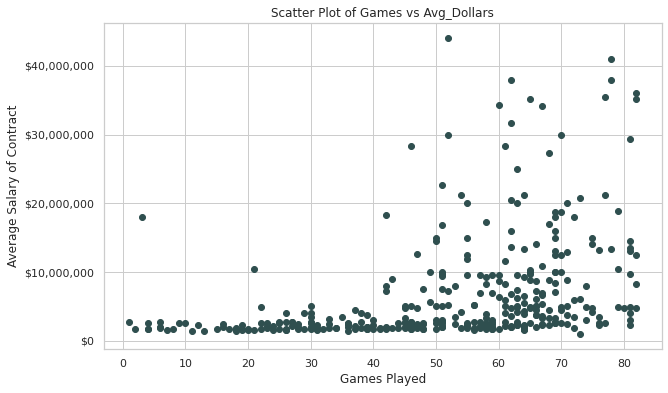

In [68]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['games'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Games Played")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Games vs Avg_Dollars")

plt.show()
plt.close()

We see with only two exceptions, everyone who played under 40 games made less than 10,000,000 dollars. However, when we get to players that played at least 40 games, the salaries are fairly varied.

### avg_dollars vs min

Now I will take a look at the relationship between avg_dollars and min. The best players usually play the most minutes, so I expect there to be a positive relationship between minutes and salary. Also, minutes is a per game statistic, which I think will make the strength of the relationship even higher.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [69]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['min'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['min'])[0])

r   =  0.6319826309683474
rho =  0.7134223592073188


The correlation coefficients suggest there is a positive relationship between the two features. However, it is not as quite as strong as I would have expected. Let's take a look at the scatter plot.

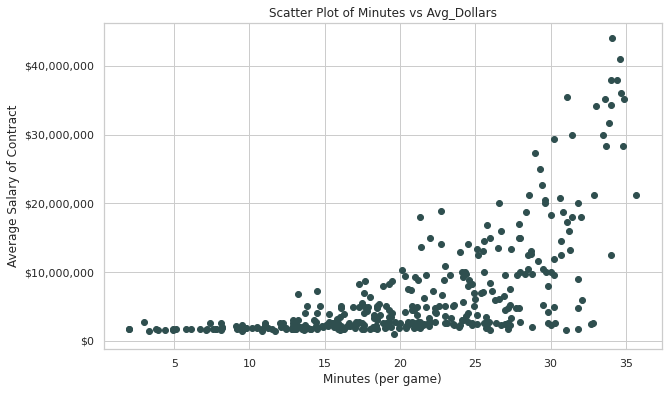

In [70]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['min'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Minutes (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Minutes vs Avg_Dollars")

plt.show()
plt.close()

We see the players that make the most money typically play the most minutes. Also, there is a decent curve in the data, suggesting there could be an exponential relationship at play.

### games vs min

As games and minutes both give information about how much a player played, I want to check if there is a relationship between these two features. This is to check if these to time related statistics could be an example of multicolinearity when it comes time to build models.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [71]:
print("r   = ", stats.pearsonr( contracts['games'], contracts['min'])[0])
print("rho = ", stats.spearmanr( contracts['games'], contracts['min'])[0])

r   =  0.5477649442912628
rho =  0.5228569856758358


There does seem to be a little relationship between the two. Let's take a look at the scatter plot of the two features.

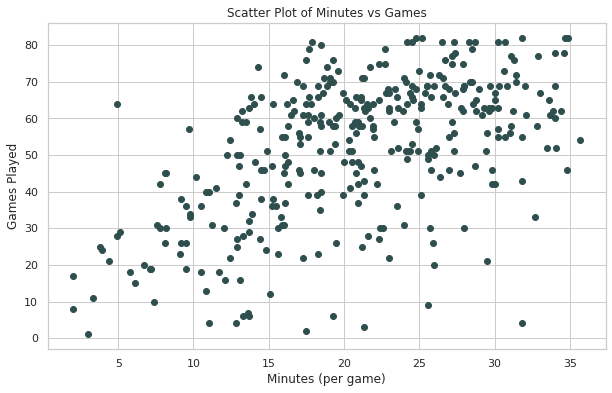

In [72]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['min'], contracts['games'], marker="o", color="darkslategray")
axes.set_xlabel("Minutes (per game)")
axes.set_ylabel("Games Played")
axes.set_title("Scatter Plot of Minutes vs Games")

plt.show()
plt.close()

Again, there does appear to be at least a little bit of relationship between the two. This is something I will keep in mind when it comes time to build the model.

### avg_dollars vs reb



After looking at some information about the players themselves and some features about playing time, we will move on to some of the other statistics related to the player's performance. In terms of salary and rebounds, I hypothesize that players who get more rebounds are more likely to make more money than players who do not grab a lot of rebounds.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [73]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['rbs'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['rbs'])[0])

r   =  0.37604626251923245
rho =  0.5283421827829052


There does not appear to be a very strong linear relationship between the two from the value of Pearson's correlation coefficient. Let's take a look at what the scatter plot looks like.

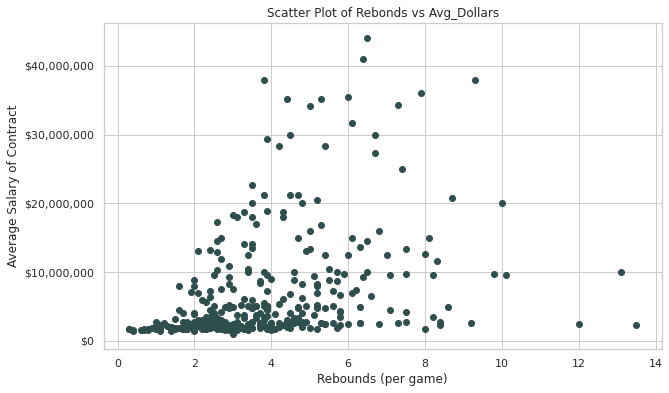

In [74]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['rbs'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Rebounds (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Rebonds vs Avg_Dollars")

plt.show()
plt.close()

There seems to be some sort of a loose linear relationship, however, the low salary values for the three players who averaged 12 rebounds per game or more seem to go against this relationship. 

### avg_dollars vs min

Now I will take a look at the relationship between avg_dollars and ast. As assists are a statistic that a lot of teams want, I believe that players who get a lot of assists will make more than players that do not. However, there are likely plenty of players who get paid very well, but have low assist numbers.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [75]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['ast'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['ast'])[0])

r   =  0.5278476542324199
rho =  0.48347478862744636


The value of Pearson's correlation coefficient is higher for assists than it was for rebounds. Let's see what the scatter plot comparing assists and avg_dollars looks like.

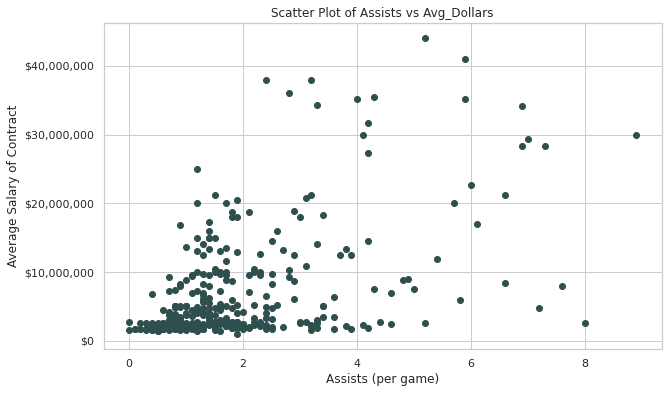

In [76]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['ast'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Assists (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Assists vs Avg_Dollars")

plt.show()
plt.close()

Much like rebounds, there are a couple of players who signed lower valued contracts and had higher assist numbers. However, you can see the upward trend in salary as assists increase.

### avg_dollars vs stl

Now I will take a look at the relationship between avg_dollars and stl. Steals are an interesting statistic because while teams are interested in players that play good defense and, thus, steal the ball a lot, I imagine that there are a lot of players with a high number of steals compared to other players that are paid extremely high. Thus, I predict that there will not be a strong relationship between steals and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [77]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['ast'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['ast'])[0])

r   =  0.5278476542324199
rho =  0.48347478862744636


While these correlation coeffecient values are not super high, they are higher than I expected. Let's take a look at what the scatter plot looks like.

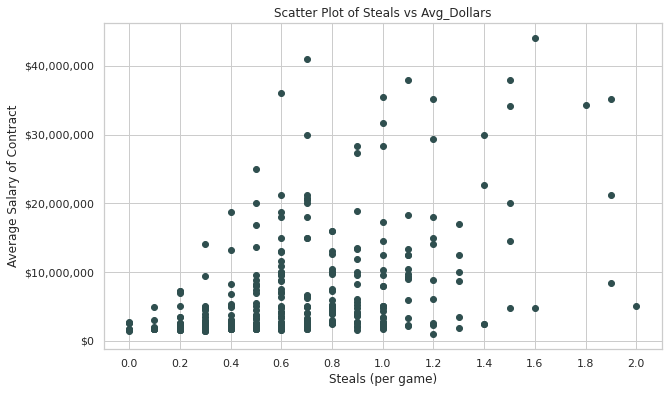

In [78]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['stl'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 11, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Steals (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Steals vs Avg_Dollars")

plt.show()
plt.close()

One thing to note from this chart is that a large number of players in the data set do not get very many steals per game. While there is an upward trend, there are a relatively small number of players who have a lot of steals compared to those with a lower number of steals.

### avg_dollars vs blk

Now I will take a look at the relationship between avg_dollars and blk. Blocks are a very important statistics for big men and post players. Thus, I expect that the big men who are paid a lot of money tend to have a high number of steals. However, there are a decent number of big men who are not paid a lot of money and there are plenty of guards who are paid a lot that block very few shots. Thus, I don't really have a prediction about the relationship between blocks and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [79]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['blk'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['blk'])[0])

r   =  0.18030975418614087
rho =  0.29819226315776803


These correlations are pretty low, suggesting there is not much of a relationship between blocks and salary.

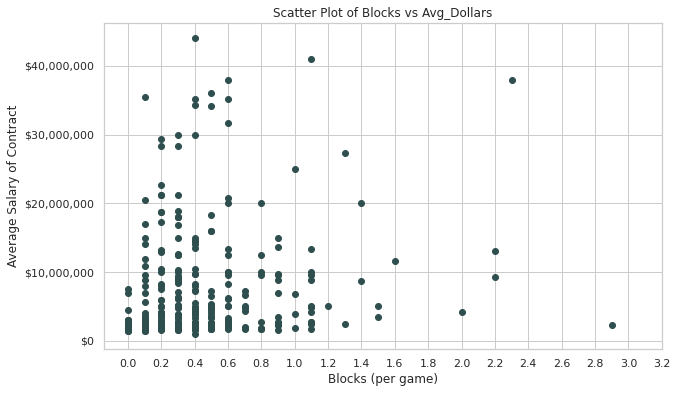

In [80]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['blk'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 17, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Blocks (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Blocks vs Avg_Dollars")

plt.show()
plt.close()

There does not appear to be much of a relationship between blocks and salary overall. Again, we should keep in mind that the vast majority of players do not block many shots. It might be interesting to see how blocks relate to salary for just the centers.

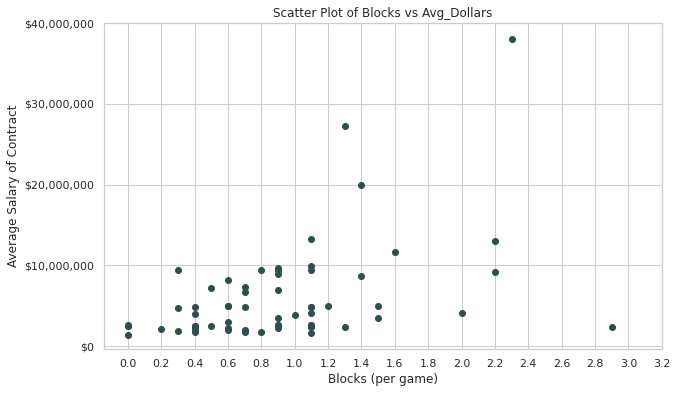

In [81]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['blk'][contracts['position']=='C'], contracts['avg_dollars'][contracts['position']=='C'],
                 marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 17, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Blocks (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Blocks vs Avg_Dollars")

plt.show()
plt.close()

This seems to show a little bit more of a relationship. What are the values of the correlation coefficients?

In [82]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'][contracts['position']=='C'],
                                   contracts['blk'][contracts['position']=='C'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'][contracts['position']=='C'],
                                   contracts['blk'][contracts['position']=='C'])[0])

r   =  0.449305848611137
rho =  0.434556070042819


While not super strong, this is more of a correlation than for all players. Something to keep in mind.

### avg_dollars vs tov

Now I will take a look at the relationship between avg_dollars and tov. Turnovers are a negative statistic, that is, you want a player to have a low number of turnovers. However, better players usually have the ball more than other players and often have higher turnover numbers simply because of the volume of time they have the ball. Therefore, I actually thing there might be a strong positive relationship between turnovers and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [83]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['tov'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['tov'])[0])

r   =  0.5848969578753296
rho =  0.5675790257507441


It looks like there could be some validity to my prediction. Let's take a look at the scatter plot.

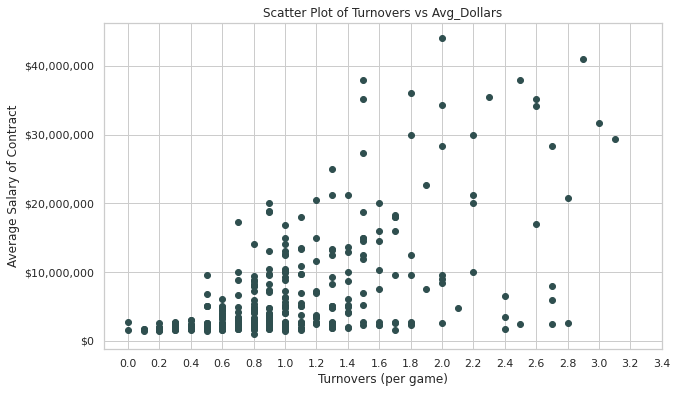

In [84]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['tov'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 18, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Turnovers (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Turnovers vs Avg_Dollars")

plt.show()
plt.close()

Based on the values for the correlation coeffecient and the scatter plot, it seems like the idea that the players who turn the ball over a lot might be making more money because them turning the ball over a lot means they have the ball a lot.

### points and fg

Before moving into the statistics about field goals and percentages and how they relate to salary. I want to take a look at pairs of features that do not include avg_salary. This is because the statistics about field goals and percentages, as well, as points likely have a high amount of overlap. Thus, I want to look into this to be wary of multicolinearity for later.

First, I will look at the relationship between points and field goals, or shots made. There is likely a very strong relationship here because making shots directly leads to points. The only way someone can score points without making a field goal is by making free throws, which are not considered field goals. Thus, I expect there to be a high positive correlation between points and field goals.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [85]:
print("r   = ", stats.pearsonr( contracts['fg'], contracts['pts'])[0])
print("rho = ", stats.spearmanr( contracts['fg'], contracts['pts'])[0])

r   =  0.9872947560574356
rho =  0.9868674299953958


As expected, the correlation is practically identical. The scatter plot should almost be a straight line.

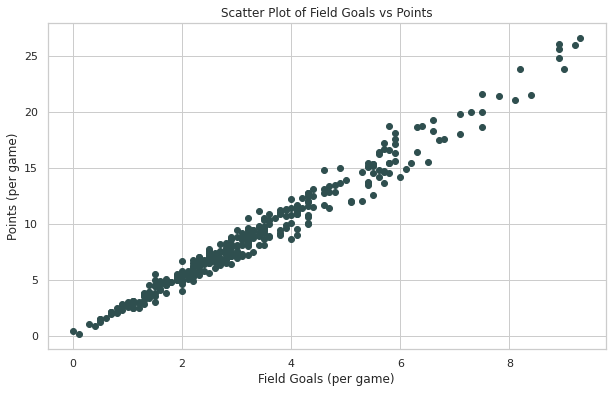

In [86]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg'], contracts['pts'], marker="o", color="darkslategray")
axes.set_xlabel("Field Goals (per game)")
axes.set_ylabel("Points (per game)")
axes.set_title("Scatter Plot of Field Goals vs Points")

plt.show()
plt.close()

There is no real reason to include both of these in the model. Thus, moving forward, I won't really look to much into field goals and will stick with points.

### points and fg_per

Second, I will look at the relationship between points and field goal percentage. I do not think there will be that strong of a relationship between these. Players with high field goal percentages are often players who take most of their shots around the basket, like centers. However, these players often do not take a lot of shots and do not shoot many three point shots. Also, players who score a lot often take a lot of tough shots, meaning there percentage is usually slightly lower. I think there might be some positive relationship, but I do not expect it to be exorbantly high.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [87]:
print("r   = ", stats.pearsonr( contracts['fg_per'], contracts['pts'])[0])
print("rho = ", stats.spearmanr( contracts['fg_per'], contracts['pts'])[0])

r   =  0.10754833309227281
rho =  0.18956710672513008


As expected, the relationship is not very strong. However, even though I predicted this correctly, I am very interested to see what the scatter plot will look like.

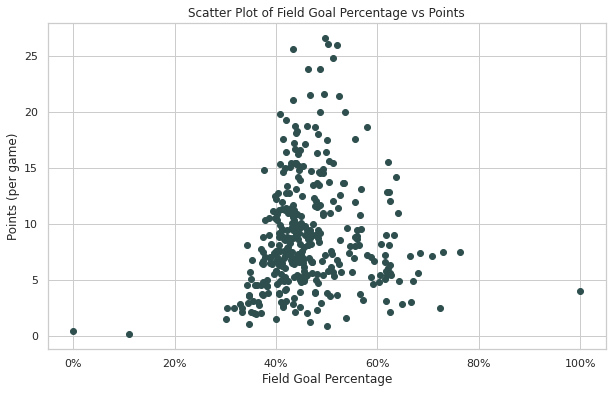

In [88]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['pts'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("Points (per game)")
axes.set_title("Scatter Plot of Field Goal Percentage vs Points")

plt.show()
plt.close()

As we can see, the vast majority of players have field goal percentages between roughly 35% and 70% and the amount of points scored based upon field goal percentage varies widely.

### fg_per and efg_per

Next, I will look at the relationship between field goal percentage and effective field goal percentage. Based on how these statistics are calculated, effective field goal percentage will always be higher than field goal percentage. And as field goal percentage rises, effective field goal percentage will rise. It is just a matter of how much, which depends on how many three point shots the player takes and makes. Nevertheless, I expect there to be a very strong relationship between the two.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [89]:
print("r   = ", stats.pearsonr( contracts['fg_per'], contracts['efg_per'])[0])
print("rho = ", stats.spearmanr( contracts['fg_per'], contracts['efg_per'])[0])

r   =  0.8800174996419798
rho =  0.8206675336331267


As expected, the correlation coefficients are very high. Let's have a look at the scatter plot.

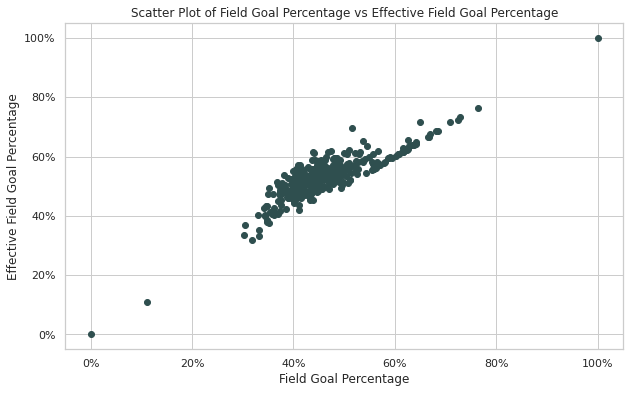

In [90]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['efg_per'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("Effective Field Goal Percentage")
axes.set_title("Scatter Plot of Field Goal Percentage vs Effective Field Goal Percentage")

plt.show()
plt.close()

While we cannot see exact values to to the clustering, the point is clearly made that they are highly correlated. I will take a closer look comparing each of these to avg_dollars to make a determination about which one to include in the model.

### three_fg and three_per

Next, I will look at the relationship between three point field goals made and three point field goal percentage. While there is likely a relationship between the two features, I am not sure how strong it will be. Mathematically speaking, if someone makes more shots, that will help their percentage of makes. However, it is very possible that someone, especially volume scorers, simply make a lot because they take a lot, not that they are making a higher percentage.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [91]:
print("r   = ", stats.pearsonr( contracts['three_fg'], contracts['three_per'])[0])
print("rho = ", stats.spearmanr( contracts['three_fg'], contracts['three_per'])[0])

r   =  0.4753359137186872
rho =  0.6287167542455576


It appears as if there is a mildly strong relationship between the two. Let's take a look at the scatter plot to get more info.

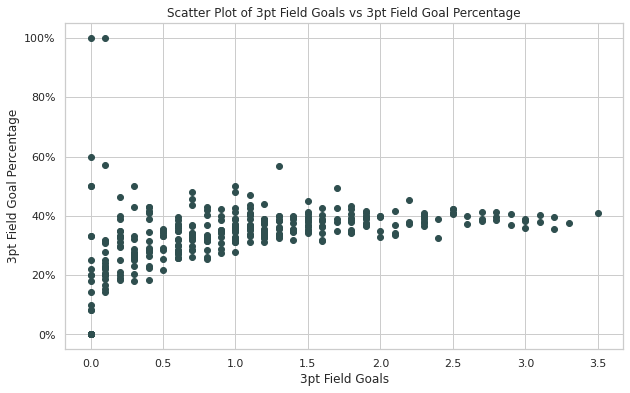

In [92]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['three_fg'], contracts['three_per'], marker="o", color="darkslategray")
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("3pt Field Goals")
axes.set_ylabel("3pt Field Goal Percentage")
axes.set_title("Scatter Plot of 3pt Field Goals vs 3pt Field Goal Percentage")

plt.show()
plt.close()

It really seems like no matter how many three point shots the a player makes, most players hover between 20% and 45%. At the moment, I am not worried about these two features with regard to multicolinearity.

### fg_per and three_per

Before moving back to relationships with avg_dollars, I want to look at the relationship between field goal percentage and three point field goal percentage. As I mentioned earlier, a lot of players with very high field goal percentages typically take most of their shots around the basket. Thus, they are likely not very good three point shooters. While a player making a higher percentage on the subset of shots they take from three will help the overall percentage, I think the players making a high percentage of three point shots and the players making a high percentage of their overall shots are different players.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [93]:
print("r   = ", stats.pearsonr( contracts['fg_per'], contracts['three_per'])[0])
print("rho = ", stats.spearmanr( contracts['fg_per'], contracts['three_per'])[0])

r   =  -0.16466954981708085
rho =  -0.0077861814931234384


These correlation coeffecient values are very close to zero, suggesting there is very little relationship between the two. A scatter plot to take a look at this visually.

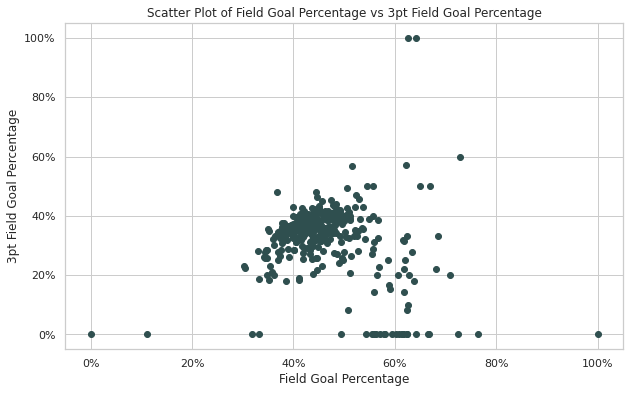

In [94]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['three_per'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("3pt Field Goal Percentage")
axes.set_title("Scatter Plot of Field Goal Percentage vs 3pt Field Goal Percentage")

plt.show()
plt.close()

There is no trend in this scatter plot to take away.

### avg_dollars vs fg_per

Returning back to average dollars, I will now take a look at the relationship between avg_dollars and field goal percentage. Teams want players who will make more shots, so I think there will be a positive relationship between field goal percentage and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [95]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['fg_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['fg_per'])[0])

r   =  0.06433361098435061
rho =  0.1746476316004869


Interestingly, there is a very low relationship between field goal percentage and avg_dollars. Let's take a look at the scatter plot to see what this looks like visually.

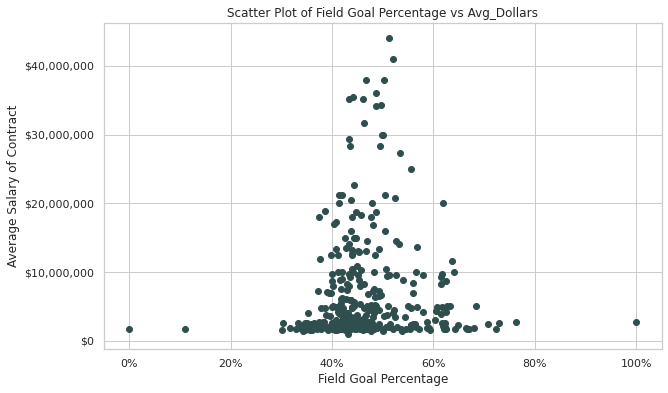

In [96]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Field Goal Percentage vs Avg_Dollars")

plt.show()
plt.close()

While up front it would seem like field goal percentage would be a think that led to a higher salary, the scatter plot and correlation coeffecients that increasing one's field goal percentage does not directly lead to a big pay day.

### avg_dollars vs efg_per

Next, I will take a look at effective field goal percentage and avg_dollars. Based on the results comparing avg_dollars and field goal percentage and the correlation between field goal percentage and effective field goal percentage, I don't think there will be much of a relationship between these two features.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [97]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['efg_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['efg_per'])[0])

r   =  0.09093950708559338
rho =  0.17055766517098025


As predicted the relationship between effective field goal percentage and average dollars does not appear to be very strong..

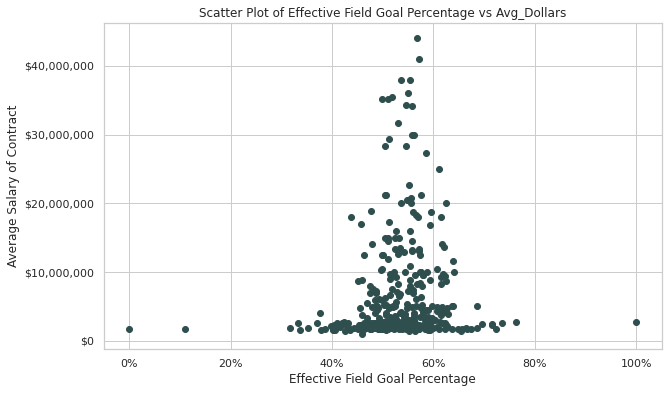

In [98]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['efg_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Effective Field Goal Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Effective Field Goal Percentage vs Avg_Dollars")

plt.show()
plt.close()

This scatter plot his almost the same exact shape as field goal percentage and avg_dollars, which is to be expected based on the strong correlation between field goal percentage and effective field goal percentage.

### avg_dollars vs three_fg

Next, I will take a look at three point field goals and avg_dollars. The three point shot is increasing in popularity and importance in today's NBA and teams are always looking to get players who can hit shots from the outside. Thus, I think that increasing the number of three point shots that someone hits will lead to an increased salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [99]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['three_fg'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['three_fg'])[0])

r   =  0.48869378033404626
rho =  0.46118026377295884


The values for the correlation coefficient seem to suggest there is only a mild relationship between three point makes and average dollars. Let's take a look at what the scatter plot of these two features looks like.

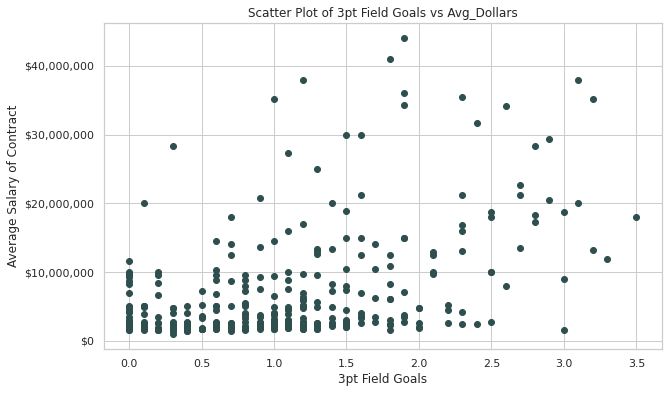

In [100]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['three_fg'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("3pt Field Goals")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of 3pt Field Goals vs Avg_Dollars")

plt.show()
plt.close()

While the players who make over 2 three point shots per game due tend to have higher salaries, the wide range of salaries for players who make between 0.5 and 2 three point shots per game affects the correlation values.

### avg_dollars vs three_per

Next, I will take a look at three point field goal percentage and avg_dollars. Based on the results comparing avg_dollars with field goal percentage and effective field goal percentage, I don't think there will be much of a relationship between these two features.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [101]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['three_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['three_per'])[0])

r   =  0.15450391760913348
rho =  0.22782938105410178


While I would by no means call these correlations high, they are higher than the correlation coeffecients comparing average dollars with field goal percentage and effective field goal percentage.

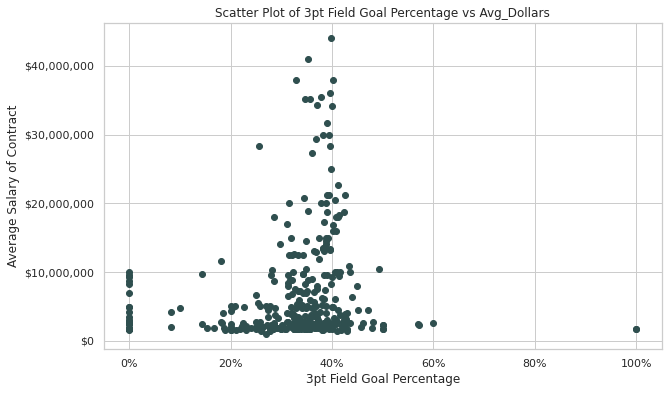

In [102]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['three_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("3pt Field Goal Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of 3pt Field Goal Percentage vs Avg_Dollars")

plt.show()
plt.close()

Again, this relationship is not super linear or strong. However, it does show that players who make above roughly 12 million dollars per season shot at least 30% or so from three.

### avg_dollars vs ft_per

Next, I will take a look at free throw percentage and avg_dollars. There have been plenty of great players in NBA history who have had very low free throw percentages and still signed large contracts, such as Giannis Antentokumpo and Shaquille O'Neal. Thus, it doesn't seem like a low free throw percentage hinders a team's willingness to pay a player, so I don't think there will be much of a relationship between free throw percentage and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [103]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['ft_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['ft_per'])[0])

r   =  0.27508846248894236
rho =  0.27423985978819354


As I expect, the correlation coefficients for this relationship are pretty low. Let's take a look at the scatter plot.

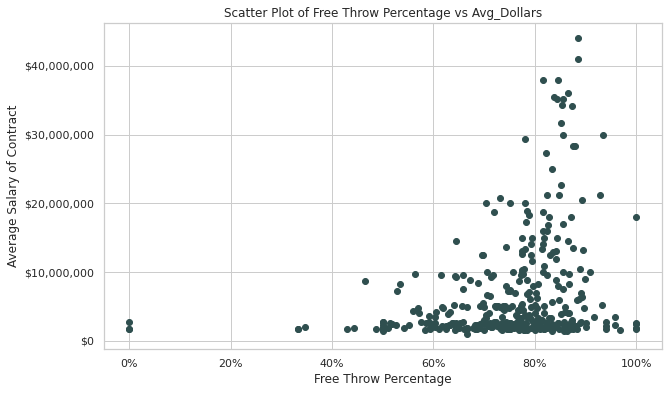

In [104]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['ft_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Free Throw Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Free Throw Percentage vs Avg_Dollars")

plt.show()
plt.close()

There does seem to be a slight increase in salary as free throw percentage increases. However, it this is by no means a home run correlation.

### avg_dollars vs position

To finish up EDA, I will take a look at how some of the categorical variables impact average dollars. First, I will look to see if a player's position effects average dollars. I believe that guards and wings, typically listed as PG, SG, or SF, will typically make more money than bigs, typically PF and C.

First, I will take a look at some descriptive statistics of average dollars for each of the different positions:

In [105]:
describe_by_category(contracts, 'avg_dollars', 'position')

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
C,66.00,"5,781,659.94","6,064,590.89","1,445,697.00","2,392,615.00","3,662,650.00","7,268,750.00","37,980,720.00"
PF,79.00,"6,339,180.75","7,040,291.01","1,489,065.00","2,069,724.00","2,641,691.00","7,277,377.00","36,000,000.00"
PG,72.00,"7,731,439.14","8,470,846.93","1,445,697.00","2,028,594.00","3,400,000.00","9,335,150.50","35,197,650.00"
SF,52.00,"8,419,414.17","11,399,410.31","1,500,000.00","2,023,056.75","2,945,485.50","9,547,312.50","44,066,288.00"
SG,86.00,"6,132,279.83","6,580,344.03","898,310.00","1,961,661.00","3,162,500.00","8,000,000.00","37,980,720.00"


All of the positions have players that make under 1.5 million dollars and over 35 million dollars. However, the mean values are highest for PG and SF. Interestingly, C has the lowest mean salary, but the highest median salary. Let's take a look at some side by side box plots to get a better visual understanding of the differences in average dollars between the positions.

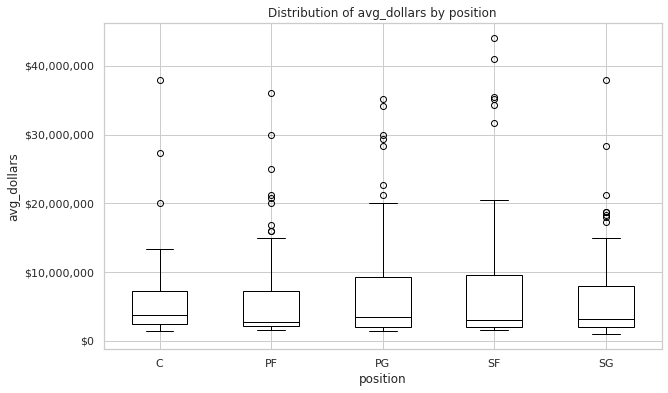

In [106]:
multiboxplot(contracts, 'avg_dollars', 'position', avg_dollars=True)

What these side by side box plots tell me that in the grand scheme of things, there are players at each position that sign large contracts. PF and SF might be slightly higher on average, but not a whole lot of difference by position.

### avg_dollars vs type

Next I will look at type of contract signed and average dollars. As we saw early, there are two types of contracts players can be signed to: Restricted Free Agent Contracts and Unrestricted Free Agent Contracts. Restricted Contracts are reserved for players who just finished there rookie deal and were not extended by their teams prior to the contract expiring. Unrestricted Contracts are for all other free agents. In general, the salaries that first time free agents, those signing restricted contracts, are capped below what someone who has been in the league for longer can make. Additionally, players that are going to sign maximum contracts after there rookie deals were likely extended by their teams and would not be in this data set. Therefore, I believe that people signing Restricted Contracts will not be as high as Unrestricted, but the mean value of these contracts is probaly at or slighlty above the mean for Unrestricted Contracts.

First, I will take a look at some descriptive statistics of average dollars for each of the different contract types:

In [107]:
describe_by_category(contracts, 'avg_dollars', 'type')

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
RFA,53.00,"8,182,842.57","7,849,054.41","1,445,697.00","2,080,000.00","4,374,000.00","12,640,000.00","31,650,600.00"
UFA,302.00,"6,524,978.14","7,872,290.52","898,310.00","2,040,416.50","2,641,691.00","7,875,000.00","44,066,288.00"


All the values for the Restricted Free Agent Contracts are higher than the Unrestricted Contracts, except for the maximum. We can see this visually in side by side box plots.

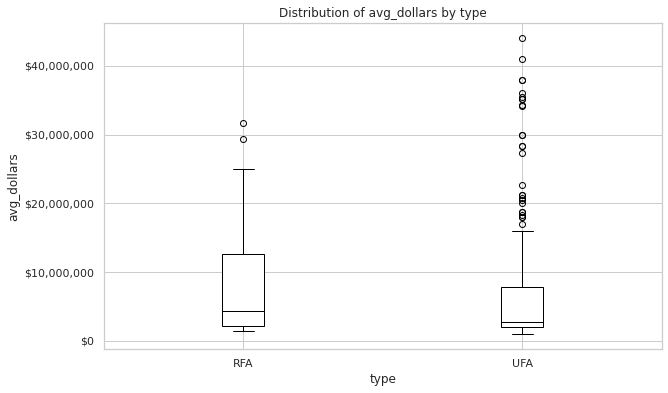

In [108]:
multiboxplot(contracts, 'avg_dollars', 'type', avg_dollars=True)

Another thing to keep in mind about `type` is that there are many more people signing Unrestricted Contracts than Restricted Contracts.

### avg_dollars vs type

Next I will look at whether or not a player resigning with his original team impacts average dollars. In today's NBA, the salary rules are structured so teams are able to offer there own players slighting more money than other teams during free agency. This rule was put into place so teams in smaller market towns, such as Milwaukee or Oklahoma City, would have a better chance of keeping star players who might leave for the New York and Los Angeles of the world if all was equal. This difference is not a lot of money, but if a player is trying to eak out every single penny they can, they can make more money by staying with the same team. Thus, I believe that players who stay with their original team, might make a little bit more money thatn those that change teams.

Taking a look at descritptive statistics split by resigning or not:

In [109]:
describe_by_category(contracts, 'avg_dollars', 'chg_team')

,count,mean,std,min,25%,50%,75%,max
chg_team,,,,,,,,
0,136.00,"7,708,143.88","8,633,831.56","898,310.00","2,231,079.50","4,050,000.00","10,000,000.00","44,066,288.00"
1,219.00,"6,191,445.15","7,333,807.58","1,445,697.00","2,028,594.00","2,641,691.00","7,339,877.00","41,063,925.00"


My prediction of players resigning with their orignal teams making slightly more money appears to be accurate. Let's take a look at the side by side box plots.

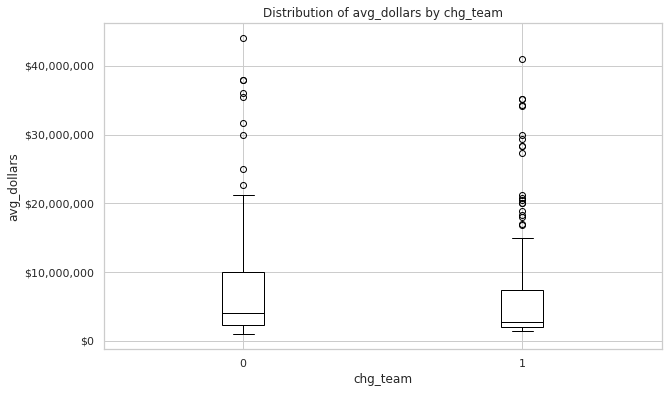

In [110]:
multiboxplot(contracts, 'avg_dollars', 'chg_team', avg_dollars=True)

Again this is not a huge difference relative to basketball salaries, but a difference does exist.

**Two Variable EDA Thoughts:** When it came to comparing individual features to avg_dollars, outside of points per game, there were not a ton of features that had extremely strong correlations with average dollars on their own. Hopefully, when the features are combined together, a model can be built that accurately predicts how much their contract will be worth.

In baskeball, teams are looking for a variety of players and skills. Everyone wants players that score lots of points. But teams also need bigs who get lots of rebounds and block shots. They also need guards who get lots of assists and make three point shots. Thus, I think that when I get into model building, I will need to build the model that values these different types of players. For example, the model should recognize that a guy who shoots a high percentage, gets a lot of rebounds, and is really tall is likely to earn a lot of money, even if they don't make a lot of threes. Similarly, if a player scores a lot and shoots a high percentage, they will still probably get a large contract even if their rebounds are slow. I will obviously get into this more in model building, but I am thinking that using position, which is usually a way to seperate players into roles or desired skills, to build different interaction terms with the statistical values could be a way to accomplish this.

In [111]:
con.close()